# Exercises - Estimating the Spot Curve

#### Notation Commands

$$\newcommand{\Black}{\mathcal{B}}
\newcommand{\Blackcall}{\Black_{\mathrm{call}}}
\newcommand{\Blackput}{\Black_{\mathrm{put}}}
\newcommand{\EcondS}{\hat{S}_{\mathrm{conditional}}}
\newcommand{\Efwd}{\mathbb{E}^{T}}
\newcommand{\Ern}{\mathbb{E}^{\mathbb{Q}}}
\newcommand{\Tfwd}{T_{\mathrm{fwd}}}
\newcommand{\Tunder}{T_{\mathrm{bond}}}
\newcommand{\accint}{A}
\newcommand{\carry}{\widetilde{\cpn}}
\newcommand{\cashflow}{C}
\newcommand{\convert}{\phi}
\newcommand{\cpn}{c}
\newcommand{\ctd}{\mathrm{CTD}}
\newcommand{\disc}{Z}
\newcommand{\done}{d_{1}}
\newcommand{\dt}{\Delta t}
\newcommand{\dtwo}{d_{2}}
\newcommand{\flatvol}{\sigma_{\mathrm{flat}}}
\newcommand{\flatvolT}{\sigma_{\mathrm{flat},T}}
\newcommand{\float}{\mathrm{flt}}
\newcommand{\freq}{m}
\newcommand{\futprice}{\mathcal{F}(t,T)}
\newcommand{\futpriceDT}{\mathcal{F}(t+h,T)}
\newcommand{\futpriceT}{\mathcal{F}(T,T)}
\newcommand{\futrate}{\mathscr{f}}
\newcommand{\fwdprice}{F(t,T)}
\newcommand{\fwdpriceDT}{F(t+h,T)}
\newcommand{\fwdpriceT}{F(T,T)}
\newcommand{\fwdrate}{f}
\newcommand{\fwdvol}{\sigma_{\mathrm{fwd}}}
\newcommand{\fwdvolTi}{\sigma_{\mathrm{fwd},T_i}}
\newcommand{\grossbasis}{B}
\newcommand{\hedge}{\Delta}
\newcommand{\ivol}{\sigma_{\mathrm{imp}}}
\newcommand{\logprice}{p}
\newcommand{\logyield}{y}
\newcommand{\mat}{(n)}
\newcommand{\nargcond}{d_{1}}
\newcommand{\nargexer}{d_{2}}
\newcommand{\netbasis}{\tilde{\grossbasis}}
\newcommand{\normcdf}{\mathcal{N}}
\newcommand{\notional}{K}
\newcommand{\pfwd}{P_{\mathrm{fwd}}}
\newcommand{\pnl}{\Pi}
\newcommand{\price}{P}
\newcommand{\probexer}{\hat{\mathcal{P}}_{\mathrm{exercise}}}
\newcommand{\pvstrike}{K^*}
\newcommand{\refrate}{r^{\mathrm{ref}}}
\newcommand{\rrepo}{r^{\mathrm{repo}}}
\newcommand{\spotrate}{r}
\newcommand{\spread}{s}
\newcommand{\strike}{K}
\newcommand{\swap}{\mathrm{sw}}
\newcommand{\swaprate}{\cpn_{\swap}}
\newcommand{\tbond}{\mathrm{fix}}
\newcommand{\ttm}{\tau}
\newcommand{\value}{V}
\newcommand{\vega}{\nu}
\newcommand{\years}{\tau}
\newcommand{\yearsACT}{\tau_{\mathrm{act/360}}}
\newcommand{\yield}{Y}$$

### Data

This exercise uses the data file, `treasury_quotes_2025-11-28`.

The problems below analyze the nominal, (rather than the TIPS,) Treasury issues. Accordingly, you should filter out all rows with `type` `TIPS Note` or `TIPS bond`.

# 1. Discount Rates

Use the data in the `selected quotes` tab.

Note:
* The selected treasuries are at nearly six-month intervals. 
* If you prefer, approximate that they mature at perfect 6-month intervals. 

### 1.1.

Create the cashflow matrix, $\textbf{C}$, where each rows is a Treasury issue, each column is a date, and each entry is the cash paid on a (normalized) face value of \$100.

In [60]:
import polars as pl
import numpy as np
from datetime import date
from dateutil.relativedelta import relativedelta

QUOTE_DATE = date(2025, 11, 28)   # use the quote/settlement anchor you intend (often settle = quote+1bd)
FACE = 100.0

selected_df = pl.read_excel("data/treasury_quotes_2025-11-28.xlsx", sheet_name="selected quotes")

# --- 1) parse maturity + coupon ---
df = selected_df.select(
    pl.col("KYTREASNO").cast(pl.Utf8),
    pl.col("maturity date").cast(pl.Date).alias("maturity"),
    pl.col("cpn rate").cast(pl.Float64).alias("cpn_rate")
)

# Semiannual coupon cash per $100
df = df.with_columns((pl.col("cpn_rate") / 2.0).alias("coupon_cash"))

ids = df["KYTREASNO"].to_list()            # list[str]
maturities = df["maturity"].to_list()      # list[date]
coupon_cash = df["coupon_cash"].to_list()  # list[float]
n = len(maturities)


# --- 2) build each bond's coupon schedule (semiannual, backwards from maturity) ---
def coupon_schedule(maturity: date, start: date) -> list[date]:
    """ Payment dates strictly after start and up to and including maturity. """
    d = maturity
    dates = [d]
    while True:
        d_prev = d - relativedelta(months=6)
        if d_prev <= start:
            break
        dates.append(d_prev)
        d = d_prev
    return sorted(dates)

from datetime import timedelta

def merge_close_dates(dates: list[date], tol_days: int = 31) -> tuple[list[date], dict[date, date]]:
    """
    Cluster sorted dates so that consecutive dates within tol_days are treated as the same column.
    Returns:
      merged_dates: representative dates (one per cluster)
      date_map: maps each original date -> representative date
    """
    dates = sorted(set(dates))
    if not dates:
        return [], {}

    merged = []
    date_map = {}

    rep = dates[0]
    merged.append(rep)
    date_map[dates[0]] = rep
    last = dates[0]

    for d in dates[1:]:
        if (d - last).days <= tol_days:
            # same cluster as current representative
            date_map[d] = rep
        else:
            # new cluster
            rep = d
            merged.append(rep)
            date_map[d] = rep
        last = d

    return merged, date_map

# --- schedules as before ---
schedules = [coupon_schedule(m, QUOTE_DATE) for m in maturities]

# union all raw cashflow dates
raw_dates = [d for sched in schedules for d in sched]

# merge any dates within 1 month (31 days)
all_dates, date_map = merge_close_dates(raw_dates, tol_days=31)

m = len(all_dates)
date_to_col = {d: j for j, d in enumerate(all_dates)}

# cashflow matrix on merged columns
C = np.zeros((n, m), dtype=float)

for i in range(n):
    mat = maturities[i]
    cpn = float(coupon_cash[i])

    for d in schedules[i]:
        d_rep = date_map[d]              # <-- snapped/unioned date
        C[i, date_to_col[d_rep]] += cpn

    # principal at (mapped) maturity bucket
    mat_rep = date_map[mat]
    C[i, date_to_col[mat_rep]] += FACE

C_df = pl.DataFrame({"KYTREASNO": ids}).hstack(
    pl.DataFrame(C.tolist(), schema=[d.isoformat() for d in all_dates])
)

C_df


/var/folders/3x/hfn6bkq11_31jjw7w90dz1f80000gn/T/ipykernel_70761/3309578300.py:102: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  pl.DataFrame(C.tolist(), schema=[d.isoformat() for d in all_dates])


KYTREASNO,2025-11-30,2026-05-15,2026-11-15,2027-05-15,2027-11-15,2028-05-15,2028-11-15,2029-05-15,2029-11-15,2030-05-15,2030-11-15,2031-05-15,2031-11-15,2032-05-15,2032-11-15,2033-05-15,2033-11-15,2034-05-15,2034-11-15,2035-05-15,2035-11-15
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""208227""",2.4375,102.4375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""208316""",2.125,2.125,102.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""208399""",1.9375,1.9375,1.9375,101.9375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""208484""",1.6875,1.6875,1.6875,1.6875,101.6875,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""208058""",1.8125,1.8125,1.8125,1.8125,1.8125,101.8125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""208147""",0.0,2.25,2.25,2.25,2.25,2.25,2.25,2.25,2.25,2.25,2.25,2.25,2.25,2.25,2.25,2.25,102.25,0.0,0.0,0.0,0.0
"""208231""",0.0,2.1875,2.1875,2.1875,2.1875,2.1875,2.1875,2.1875,2.1875,2.1875,2.1875,2.1875,2.1875,2.1875,2.1875,2.1875,2.1875,102.1875,0.0,0.0,0.0
"""208320""",0.0,2.125,2.125,2.125,2.125,2.125,2.125,2.125,2.125,2.125,2.125,2.125,2.125,2.125,2.125,2.125,2.125,2.125,102.125,0.0,0.0


### 1.2.

Estimate the spot discount factors that rationalize the market prices of the treasuries. Do this via solving the linear system

$$\textbf{p} = {\textbf{C}}\, \textbf{z}$$

In [61]:
# Price vector
p = selected_df.select(pl.col("price").cast(pl.Float64)).to_series() # Clean price

z, residuals, rank, s = np.linalg.lstsq(C, p, rcond=None)
z_df = pl.DataFrame({
    "date": [d.isoformat() for d in all_dates],
    "discount_factor": z.tolist(),
})

### 1.3.

Plot the time-to-maturity on the horizontal axis. On the vertical axis, plot the...
* discount factors

Make another plot, this time with the vertical axis displaying the
* semiannually compounded discount rates
* continuously compounded discount rates

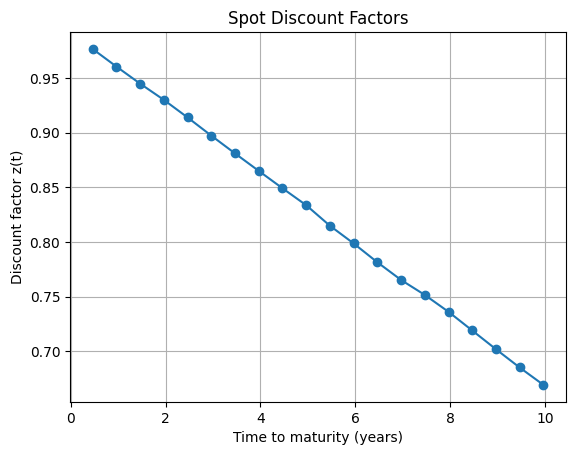

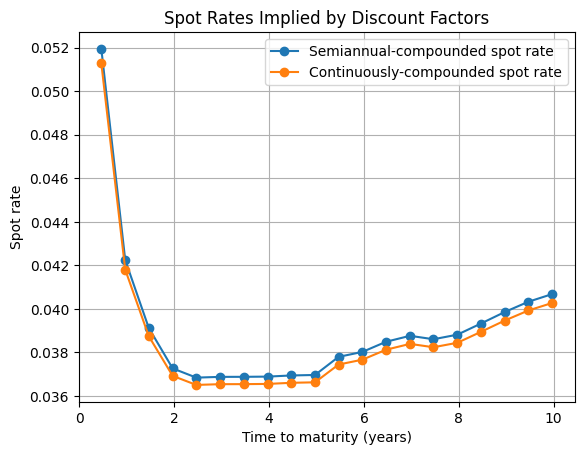

In [62]:
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
from datetime import date

# --- 1) time-to-maturity in years for each discount factor date ---
t = np.array([(d - QUOTE_DATE).days / 365.0 for d in all_dates], dtype=float)  # shape (m,)
z = np.array(z, dtype=float)

# --- 2) Plot discount factors vs time-to-maturity ---
plt.figure()
plt.plot(t[1:], z[1:], marker="o")
plt.xlabel("Time to maturity (years)")
plt.ylabel("Discount factor z(t)")
plt.title("Spot Discount Factors")
plt.grid(True)
plt.show()

# --- 3) Convert discount factors -> discount rates ---
# Semiannual-compounded spot rate r_sa(t): z(t) = (1 + r/2)^(-2t)  =>  r = 2 * ( z^(-1/(2t)) - 1 )
# Continuously-compounded spot rate r_cc(t): z(t) = exp(-r t)        =>  r = -ln(z)/t

r_sa = 2.0 * (z ** (-1.0 / (2.0 * t)) - 1.0)
r_cc = -np.log(z) / t

# --- 4) Plot discount rates vs time-to-maturity ---
plt.figure()
plt.plot(t[1:], r_sa[1:], marker="o", label="Semiannual-compounded spot rate")
plt.plot(t[1:], r_cc[1:], marker="o", label="Continuously-compounded spot rate")
plt.xlabel("Time to maturity (years)")
plt.ylabel("Spot rate")
plt.title("Spot Rates Implied by Discount Factors")
plt.grid(True)
plt.legend()
plt.show()


### 1.4. Curve-Fitting

Estimate the discount curve via the Nelson-Siegel model.
* Fit via minimizing the sum of squared errors of the modeled prices against the quoted prices.
* Consider using `minimize` from `scipy.optimize`.

When done,
* Report the estimated NS parameters.
* Plot the semiannually-compounded discount rates along with those estimated with OLS from above.

Nelson-Siegel parameter estimates:
beta0 = 0.037537
beta1 = 0.162996
beta2 = -0.127792
tau   = 0.369973


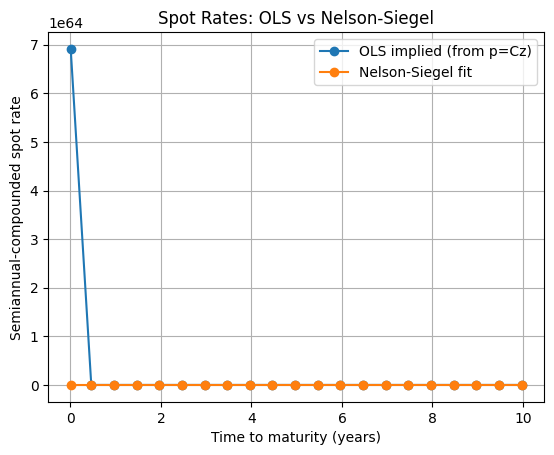

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# --- Inputs you already have / should set ---
p = selected_df["price"].to_numpy()

# time grid in years for each cashflow date
t = np.array([(d - QUOTE_DATE).days / 365.0 for d in all_dates], dtype=float)

# --- Nelson–Siegel functions ---
def ns_zero_rate_cc(t, beta0, beta1, beta2, tau):
    """
    Nelson-Siegel continuously-compounded zero rate y(t).
    t: array of maturities in years (t>0)
    """
    x = t / tau
    # (1 - e^{-x})/x is well-behaved as x->0; use series-safe expression
    a = (1.0 - np.exp(-x)) / x
    b = a - np.exp(-x)
    return beta0 + beta1 * a + beta2 * b

def ns_discount_factors(t, params):
    beta0, beta1, beta2, tau = params
    y = ns_zero_rate_cc(t, beta0, beta1, beta2, tau)
    return np.exp(-y * t)

def price_sse(params, C, p, t):
    # enforce tau>0 via bounds; still guard against numerical issues
    z = ns_discount_factors(t, params)
    phat = C @ z
    err = phat - p
    return float(err @ err)  # SSE

# --- Initial guess + bounds ---
# beta0 ~ long-run level; set near long end OLS continuous rate (or just a small positive)
# Roughly convert OLS DF to cc rate for initialization:
r_cc_ols = -np.log(z) / t
beta0_0 = float(np.median(r_cc_ols[-min(5, len(r_cc_ols)):]))  # median of last few points
x0 = np.array([beta0_0, -0.02, 0.02, 1.5], dtype=float)       # [beta0,beta1,beta2,tau]

# Bounds: keep tau positive; betas in a reasonable range (adjust if needed)
bnds = [(-0.10, 0.20), (-0.50, 0.50), (-0.50, 0.50), (0.05, 20.0)]

res = minimize(
    price_sse,
    x0=x0,
    args=(C, p, t),
    method="L-BFGS-B",
    bounds=bnds,
)

beta0_hat, beta1_hat, beta2_hat, tau_hat = res.x
print("Nelson-Siegel parameter estimates:")
print(f"beta0 = {beta0_hat:.6f}")
print(f"beta1 = {beta1_hat:.6f}")
print(f"beta2 = {beta2_hat:.6f}")
print(f"tau   = {tau_hat:.6f}")

# --- Compute fitted curve and compare to OLS ---
z_ns = ns_discount_factors(t, res.x)
r_sa_ns = 2.0 * (z_ns ** (-1.0 / (2.0 * t)) - 1.0)

# --- Plot: semiannual-compounded discount rates (NS vs OLS) ---
plt.figure()
plt.plot(t, r_sa, marker="o", label="OLS implied (from p=Cz)")
plt.plot(t, r_sa_ns, marker="o", label="Nelson-Siegel fit")
plt.xlabel("Time to maturity (years)")
plt.ylabel("Semiannual-compounded spot rate")
plt.title("Spot Rates: OLS vs Nelson-Siegel")
plt.grid(True)
plt.legend()
plt.show()


# 2. Estimating the Discount Curve with Non-Evenly Spaced Data

Use the data in the `quotes` tab.

### 2.1. Map Cashflows

Construct the cashflow matrix.

Given the unfiltered data set, you will need to make a few modeling choices to do this...
* eliminate any treasury that does not report YTM or that reports a negative YTM.
* assume notes and bonds pay coupons every six months, going backward from the date of maturity.

Make other reasonable modeling assumptions as needed.

Report:
* head and tail rows of the dataframe, $\textbf{C}$, for instance, using `display()`.

* which date has the most cashflow across all issues?

* which date has the most issues paying a cashflow?

In [64]:
import polars as pl
import numpy as np
from datetime import date
from dateutil.relativedelta import relativedelta

QUOTE_DATE = date(2025, 11, 28)
FACE = 100.0
import polars as pl
import datetime as dt

raw_data = pl.read_excel("data/treasury_quotes_2025-11-28.xlsx", sheet_name='quotes')

# --- Filter: valid, non-negative YTM ---
filtered_df = (
    raw_data
    .filter(~(pl.col("type") == "TIPS note"),
            ~(pl.col("type") == "TIPS bond"))
    .filter(pl.col("ytm").is_not_null())
    .filter(pl.col("ytm") >= 0)
    .select(
        pl.col("KYTREASNO").cast(pl.Utf8),
        pl.col("maturity date").cast(pl.Date).alias("maturity"),
        pl.col("cpn rate").cast(pl.Float64).alias("cpn_rate"),
        pl.col("price").cast(pl.Float64).alias("price"),
        pl.col("ytm").cast(pl.Float64).alias("ytm"),
    )
)

# Semiannual coupon cash per $100
filtered_df = filtered_df.with_columns(
    (pl.col("cpn_rate") / 2.0).alias("coupon_cash")
)

ids = filtered_df["KYTREASNO"].to_list()
maturities = filtered_df["maturity"].to_list()
coupon_cash = filtered_df["coupon_cash"].to_list()
n = len(maturities)

schedules = [coupon_schedule(m, QUOTE_DATE) for m in maturities]

raw_dates = [d for sched in schedules for d in sched]
all_dates, date_map = merge_close_dates(raw_dates, tol_days=0)
date_to_col = {d: j for j, d in enumerate(all_dates)}
m = len(all_dates)

C = np.zeros((n, m), dtype=float)

for i in range(n):
    cpn = float(coupon_cash[i])
    for d in schedules[i]:
        j = date_to_col[date_map[d]]
        C[i, j] += cpn

    # principal at maturity
    j_mat = date_to_col[date_map[maturities[i]]]
    C[i, j_mat] += FACE

C_df = pl.DataFrame({"KYTREASNO": ids}).hstack(
    pl.DataFrame(C.tolist(), schema=[d.isoformat() for d in all_dates])
)

C_df

/var/folders/3x/hfn6bkq11_31jjw7w90dz1f80000gn/T/ipykernel_70761/2164420305.py:59: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  pl.DataFrame(C.tolist(), schema=[d.isoformat() for d in all_dates])


KYTREASNO,2025-11-30,2025-12-02,2025-12-04,2025-12-09,2025-12-11,2025-12-15,2025-12-16,2025-12-18,2025-12-23,2025-12-26,2025-12-30,2025-12-31,2026-01-02,2026-01-06,2026-01-08,2026-01-09,2026-01-13,2026-01-15,2026-01-20,2026-01-22,2026-01-27,2026-01-29,2026-01-31,2026-02-03,2026-02-05,2026-02-06,2026-02-10,2026-02-12,2026-02-15,2026-02-17,2026-02-19,2026-02-24,2026-02-26,2026-02-28,2026-03-03,2026-03-05,…,2046-11-15,2047-02-15,2047-05-15,2047-08-15,2047-11-15,2048-02-15,2048-05-15,2048-08-15,2048-11-15,2049-02-15,2049-05-15,2049-08-15,2049-11-15,2050-02-15,2050-05-15,2050-08-15,2050-11-15,2051-02-15,2051-05-15,2051-08-15,2051-11-15,2052-02-15,2052-05-15,2052-08-15,2052-11-15,2053-02-15,2053-05-15,2053-08-15,2053-11-15,2054-02-15,2054-05-15,2054-08-15,2054-11-15,2055-02-15,2055-05-15,2055-08-15,2055-11-15
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""208422""",0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""208397""",0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""208432""",0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""208410""",0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""207988""",0.0,0.0,0.0,0.0,0.0,102.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""208322""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,2.25,0.0,2.25,0.0,2.25,0.0,2.25,0.0,2.25,0.0,2.25,0.0,2.25,0.0,2.25,0.0,2.25,0.0,2.25,0.0,2.25,0.0,2.25,0.0,2.25,0.0,2.25,0.0,2.25,0.0,2.25,0.0,102.25,0.0,0.0,0.0,0.0
"""208362""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.3125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,102.3125,0.0,0.0,0.0
"""208405""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,102.375,0.0,0.0


In [65]:
# Head and tail of the cashflow matrix
display(C_df.head())
display(C_df.tail())


KYTREASNO,2025-11-30,2025-12-02,2025-12-04,2025-12-09,2025-12-11,2025-12-15,2025-12-16,2025-12-18,2025-12-23,2025-12-26,2025-12-30,2025-12-31,2026-01-02,2026-01-06,2026-01-08,2026-01-09,2026-01-13,2026-01-15,2026-01-20,2026-01-22,2026-01-27,2026-01-29,2026-01-31,2026-02-03,2026-02-05,2026-02-06,2026-02-10,2026-02-12,2026-02-15,2026-02-17,2026-02-19,2026-02-24,2026-02-26,2026-02-28,2026-03-03,2026-03-05,…,2046-11-15,2047-02-15,2047-05-15,2047-08-15,2047-11-15,2048-02-15,2048-05-15,2048-08-15,2048-11-15,2049-02-15,2049-05-15,2049-08-15,2049-11-15,2050-02-15,2050-05-15,2050-08-15,2050-11-15,2051-02-15,2051-05-15,2051-08-15,2051-11-15,2052-02-15,2052-05-15,2052-08-15,2052-11-15,2053-02-15,2053-05-15,2053-08-15,2053-11-15,2054-02-15,2054-05-15,2054-08-15,2054-11-15,2055-02-15,2055-05-15,2055-08-15,2055-11-15
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""208422""",0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""208397""",0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""208432""",0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""208410""",0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""207988""",0.0,0.0,0.0,0.0,0.0,102.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


KYTREASNO,2025-11-30,2025-12-02,2025-12-04,2025-12-09,2025-12-11,2025-12-15,2025-12-16,2025-12-18,2025-12-23,2025-12-26,2025-12-30,2025-12-31,2026-01-02,2026-01-06,2026-01-08,2026-01-09,2026-01-13,2026-01-15,2026-01-20,2026-01-22,2026-01-27,2026-01-29,2026-01-31,2026-02-03,2026-02-05,2026-02-06,2026-02-10,2026-02-12,2026-02-15,2026-02-17,2026-02-19,2026-02-24,2026-02-26,2026-02-28,2026-03-03,2026-03-05,…,2046-11-15,2047-02-15,2047-05-15,2047-08-15,2047-11-15,2048-02-15,2048-05-15,2048-08-15,2048-11-15,2049-02-15,2049-05-15,2049-08-15,2049-11-15,2050-02-15,2050-05-15,2050-08-15,2050-11-15,2051-02-15,2051-05-15,2051-08-15,2051-11-15,2052-02-15,2052-05-15,2052-08-15,2052-11-15,2053-02-15,2053-05-15,2053-08-15,2053-11-15,2054-02-15,2054-05-15,2054-08-15,2054-11-15,2055-02-15,2055-05-15,2055-08-15,2055-11-15
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""208322""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,2.25,0.0,2.25,0.0,2.25,0.0,2.25,0.0,2.25,0.0,2.25,0.0,2.25,0.0,2.25,0.0,2.25,0.0,2.25,0.0,2.25,0.0,2.25,0.0,2.25,0.0,2.25,0.0,2.25,0.0,2.25,0.0,102.25,0.0,0.0,0.0,0.0
"""208362""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.3125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,102.3125,0.0,0.0,0.0
"""208405""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,102.375,0.0,0.0
"""208448""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,102.375,0.0
"""208490""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,102.3125


In [66]:
cash_by_date = C.sum(axis=0)
idx_max_cash = np.argmax(cash_by_date)

most_cash_date = all_dates[idx_max_cash]
most_cash_amount = cash_by_date[idx_max_cash]

print("The date with the most cash is", most_cash_date, "with a total of", most_cash_amount)

The date with the most cash is 2026-04-30 with a total of 444.5


In [67]:
issues_by_date = (C > 0).sum(axis=0)
idx_max_issues = np.argmax(issues_by_date)

most_issues_date = all_dates[idx_max_issues]
most_issues_count = issues_by_date[idx_max_issues]

print("The date with the most issues is", most_issues_date, "with a total of", most_issues_count, "issues.")

The date with the most issues is 2026-02-15 with a total of 82 issues.


### 2.2. OLS

Estimate the discount factors using OLS.

Starting with the cashflow matrix, $C$, create an additional filter to get a subset where every date has at least one maturity, (possibly multiple,) and every issue has its maturity in the cashflow matrix. Call this set of cashflows, $\hat{C}$.

**Report 5 head and tail rows of $\hat{C}$.**

$$\textbf{p} = \hat{\textbf{C}}\,\textbf{z}_{\text{ols}}+\epsilon$$

Plot the time-to-maturity vs discount rates, semiannually compounded.

In [79]:
import numpy as np
import polars as pl

# column indices that contain at least one principal payment
principal_cols = np.where((C >= 100).any(axis=0))[0]

# corresponding dates
principal_dates = {all_dates[j] for j in principal_cols}

# rows (issues) whose maturity date is represented
row_mask = np.array([m in principal_dates for m in maturities])

# columns (dates) that have at least one maturity
col_mask = np.zeros(C.shape[1], dtype=bool)
col_mask[principal_cols] = True

C_hat = C[row_mask][:, col_mask]
maturities_hat = np.array(maturities)[row_mask]

ids_hat = np.array(ids)[row_mask]
dates_hat = [d for d, keep in zip(all_dates, col_mask) if keep]

C_hat_df = pl.DataFrame({"KYTREASNO": ids_hat.tolist()}).hstack(
    pl.DataFrame(C_hat.tolist(), schema=[d.isoformat() for d in dates_hat])
)

display(C_hat_df.head(5))
display(C_hat_df.tail(5))

/var/folders/3x/hfn6bkq11_31jjw7w90dz1f80000gn/T/ipykernel_70761/3663546131.py:24: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  pl.DataFrame(C_hat.tolist(), schema=[d.isoformat() for d in dates_hat])


KYTREASNO,2025-12-02,2025-12-04,2025-12-09,2025-12-11,2025-12-15,2025-12-16,2025-12-18,2025-12-23,2025-12-26,2025-12-30,2025-12-31,2026-01-02,2026-01-06,2026-01-08,2026-01-13,2026-01-15,2026-01-20,2026-01-22,2026-01-27,2026-01-29,2026-01-31,2026-02-03,2026-02-05,2026-02-10,2026-02-12,2026-02-15,2026-02-17,2026-02-19,2026-02-24,2026-02-26,2026-02-28,2026-03-03,2026-03-05,2026-03-10,2026-03-12,2026-03-15,…,2046-11-15,2047-02-15,2047-05-15,2047-08-15,2047-11-15,2048-02-15,2048-05-15,2048-08-15,2048-11-15,2049-02-15,2049-05-15,2049-08-15,2049-11-15,2050-02-15,2050-05-15,2050-08-15,2050-11-15,2051-02-15,2051-05-15,2051-08-15,2051-11-15,2052-02-15,2052-05-15,2052-08-15,2052-11-15,2053-02-15,2053-05-15,2053-08-15,2053-11-15,2054-02-15,2054-05-15,2054-08-15,2054-11-15,2055-02-15,2055-05-15,2055-08-15,2055-11-15
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""208422""",100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""208397""",0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""208432""",0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""208410""",0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""207988""",0.0,0.0,0.0,0.0,102.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


KYTREASNO,2025-12-02,2025-12-04,2025-12-09,2025-12-11,2025-12-15,2025-12-16,2025-12-18,2025-12-23,2025-12-26,2025-12-30,2025-12-31,2026-01-02,2026-01-06,2026-01-08,2026-01-13,2026-01-15,2026-01-20,2026-01-22,2026-01-27,2026-01-29,2026-01-31,2026-02-03,2026-02-05,2026-02-10,2026-02-12,2026-02-15,2026-02-17,2026-02-19,2026-02-24,2026-02-26,2026-02-28,2026-03-03,2026-03-05,2026-03-10,2026-03-12,2026-03-15,…,2046-11-15,2047-02-15,2047-05-15,2047-08-15,2047-11-15,2048-02-15,2048-05-15,2048-08-15,2048-11-15,2049-02-15,2049-05-15,2049-08-15,2049-11-15,2050-02-15,2050-05-15,2050-08-15,2050-11-15,2051-02-15,2051-05-15,2051-08-15,2051-11-15,2052-02-15,2052-05-15,2052-08-15,2052-11-15,2053-02-15,2053-05-15,2053-08-15,2053-11-15,2054-02-15,2054-05-15,2054-08-15,2054-11-15,2055-02-15,2055-05-15,2055-08-15,2055-11-15
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""208322""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,2.25,0.0,2.25,0.0,2.25,0.0,2.25,0.0,2.25,0.0,2.25,0.0,2.25,0.0,2.25,0.0,2.25,0.0,2.25,0.0,2.25,0.0,2.25,0.0,2.25,0.0,2.25,0.0,2.25,0.0,2.25,0.0,102.25,0.0,0.0,0.0,0.0
"""208362""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.3125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,102.3125,0.0,0.0,0.0
"""208405""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,102.375,0.0,0.0
"""208448""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,2.375,0.0,102.375,0.0
"""208490""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,2.3125,0.0,102.3125


In [71]:
# Build a small DF of retained IDs
ids_hat_df = pl.DataFrame({"KYTREASNO": ids_hat.tolist()})

# Join back to filtered_df to get prices
p_hat = (
    filtered_df
    .with_columns(pl.col("KYTREASNO").cast(pl.Utf8))
    .join(ids_hat_df, on="KYTREASNO", how="inner")
    .select("price")
    .to_numpy()
    .ravel()
)

# OLS
z_ols, residuals, rank, s = np.linalg.lstsq(C_hat, p_hat, rcond=None)

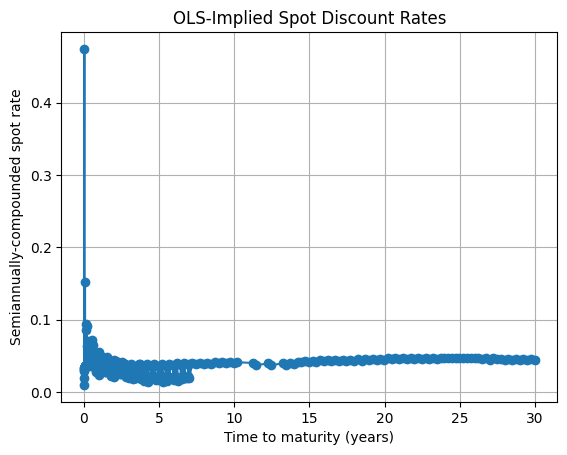

In [73]:
from datetime import date

QUOTE_DATE = date(2025, 11, 28)

t = np.array([(d - QUOTE_DATE).days / 365.0 for d in dates_hat])
t_safe = np.maximum(t, 1e-12)

# semiannual spot rates
r_sa_ols = 2.0 * (z_ols ** (-1.0 / (2.0 * t_safe)) - 1.0)

plt.figure()
plt.plot(t, r_sa_ols, marker="o")
plt.xlabel("Time to maturity (years)")
plt.ylabel("Semiannually-compounded spot rate")
plt.title("OLS-Implied Spot Discount Rates")
plt.grid(True)
plt.show()


### 2.3. Nelson-Siegel Curve-Fitting

As in `1.4`, estimate the Nelson-Siegel curve.

Nelson-Siegel parameter estimates (fit on Ĉ):
beta0 = 0.053783
beta1 = 0.018769
beta2 = -0.121411
tau   = 1.672230


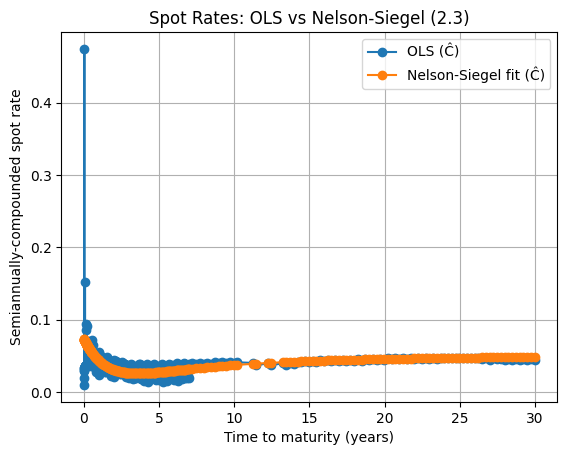

In [74]:
from scipy.optimize import minimize

t = np.array([(d - QUOTE_DATE).days / 365.0 for d in dates_hat], dtype=float)
t_safe = np.maximum(t, 1e-12)

# --- Initial guess ---
# Use OLS-implied continuous spot rates to seed beta0
r_cc_ols = -np.log(np.maximum(z_ols, 1e-12)) / t_safe
beta0_0 = float(np.median(r_cc_ols[-min(5, len(r_cc_ols)):]))
x0 = np.array([beta0_0, -0.02, 0.02, 1.5], dtype=float)

# --- Bounds (tau > 0) ---
bnds = [(-0.10, 0.25), (-1.00, 1.00), (-1.00, 1.00), (0.05, 30.0)]

res = minimize(
    price_sse,
    x0=x0,
    args=(C_hat, p_hat, t),
    method="L-BFGS-B",
    bounds=bnds,
)

if not res.success:
    print("Optimization warning:", res.message)

beta0_hat, beta1_hat, beta2_hat, tau_hat = res.x
print("Nelson-Siegel parameter estimates (fit on Ĉ):")
print(f"beta0 = {beta0_hat:.6f}")
print(f"beta1 = {beta1_hat:.6f}")
print(f"beta2 = {beta2_hat:.6f}")
print(f"tau   = {tau_hat:.6f}")

# --- Fitted curve on the same date grid ---
z_ns = ns_discount_factors(t, res.x)

# semiannual-compounded spot rates for plotting
r_sa_ols = 2.0 * (np.maximum(z_ols, 1e-12) ** (-1.0 / (2.0 * t_safe)) - 1.0)
r_sa_ns  = 2.0 * (z_ns ** (-1.0 / (2.0 * t_safe)) - 1.0)

# --- Plot: OLS vs NS (semiannual-compounded spot rates) ---
plt.figure()
plt.plot(t, r_sa_ols, marker="o", label="OLS (Ĉ)")
plt.plot(t, r_sa_ns, marker="o", label="Nelson-Siegel fit (Ĉ)")
plt.xlabel("Time to maturity (years)")
plt.ylabel("Semiannually-compounded spot rate")
plt.title("Spot Rates: OLS vs Nelson-Siegel (2.3)")
plt.grid(True)
plt.legend()
plt.show()

### 2.4. Weighted Least Squares

Re-do `2.2.`, but this time use Weighted Least Squares. Find a weighting scheme that puts more weight on more recently issued treasures and less weight on less recently issued treasures. 

Does your answer change much?

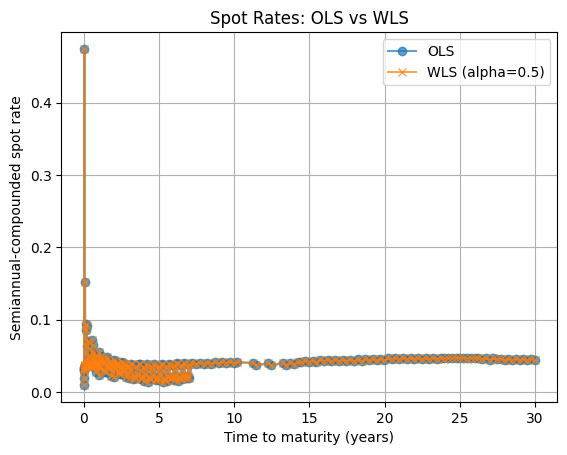

In [89]:
# maturities_hat must be length n_hat (rows)
T = np.array([(m - QUOTE_DATE).days / 365.0 for m in maturities_hat], dtype=float)

alpha = 0.5
w = np.exp(-alpha * T)
w = w / np.mean(w)
sqrt_w = np.sqrt(w)

# Now this will broadcast correctly: (402,270) * (402,1)
Cw = C_hat * sqrt_w[:, None]
pw = p_hat * sqrt_w


z_wls, residuals, rank, s = np.linalg.lstsq(Cw, pw, rcond=None)

t = np.array([(d - QUOTE_DATE).days / 365.0 for d in dates_hat], dtype=float)
eps = 1e-12
t_safe = np.maximum(t, eps)

r_sa_ols = 2.0 * (np.maximum(z_ols, eps) ** (-1.0 / (2.0 * t_safe)) - 1.0)
r_sa_wls = 2.0 * (np.maximum(z_wls, eps) ** (-1.0 / (2.0 * t_safe)) - 1.0)

plt.figure()
plt.plot(t, r_sa_ols, marker="o", label="OLS", alpha=0.7)
plt.plot(t, r_sa_wls, marker="x", label=f"WLS (alpha={alpha})", alpha=0.7)
plt.xlabel("Time to maturity (years)")
plt.ylabel("Semiannual-compounded spot rate")
plt.title("Spot Rates: OLS vs WLS")
plt.grid(True)
plt.legend()
plt.show()

In [84]:
rmse_ols = np.sqrt(np.mean((C_hat @ z_ols - p_hat)**2))
rmse_wls = np.sqrt(np.mean((C_hat @ z_wls - p_hat)**2))

wrmse_ols = np.sqrt(np.mean(w * (C_hat @ z_ols - p_hat)**2))
wrmse_wls = np.sqrt(np.mean(w * (C_hat @ z_wls - p_hat)**2))

print(f"RMSE OLS: {rmse_ols:.6f}, WLS: {rmse_wls:.6f}")
print(f"Weighted RMSE OLS: {wrmse_ols:.6f}, WLS: {wrmse_wls:.6f}")

RMSE OLS: 0.524189, WLS: 0.524454
Weighted RMSE OLS: 0.457802, WLS: 0.457714


The WLS estimates are very close to the OLS estimates. Weighting recent issues more heavily improves the weighted fit slightly but does not materially alter the implied discount curve.

***